# Single user profiling

In this notebook, we analyze the process chosen for profiling, with a single user. This study goes in the direction of exploring the potential of the proposed approach in extracting profiles in a hierarchical way.

## Imports

In [1]:
import pandas as pd

import numpy as np
import random

import os
from collections import Counter
import pickle

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

import seaborn as sns

from sklearn.cluster import KMeans

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

import xgboost as xgb

from time import time

from gcd_dask_mgmt import extract_delayed_dask_dataframe

from clustering_functions import extract_kmeans_stats

from plot_functions import plot_silhouette_results
from plot_functions import plot_feature_scatter

## Load data

In [2]:
readings_task_usage_df = pd.read_csv("data/sample_jobs_summary_10perc.csv", header=[0,1], index_col=[0])

In [3]:
static_metrics = pd.read_csv('data/static_metrics_and_kmeans.csv')

In [4]:
users_analysis = static_metrics.groupby(["user"])["logical job name"].nunique()

In [5]:
users_analysis[(users_analysis > 10) & (users_analysis < 100)].sort_values(ascending=False).head(10)

user
Nugr6rX+U6WELDvGY6ars76339mw/Uc2fgD1/rZ6fkA=    97
Op11yM+i4aMyxMb8N6hFedpCfOPvx2DrE+hMR89KQhM=    95
JbqRxZYX7GvL8n1DA2FRayE2ZzbB9bFinfQtV/GwKDM=    92
vXgLfCPJ4LrZfulMjeDWkrZt6QtgdPccp2zduVjmyYQ=    87
XXdY557FQk791swgplLkVfyX7Vr1lIHuSKR+pnbZWR8=    86
AeI72OXfCjMJ4HAzwOV8am5Nt8EySEb8mNMsXdrC/GM=    79
r/Al6kYJOwZITr6wi4pAlEwyGv5TM2EkJ8woA5hszeA=    75
f7F3iYlP9QqyuUyW8v/H8sCjOf6XEy+lP3bzejIRLK0=    75
tbZPogOJtA44Ygqw4BwvPZtCKXXYfYruoPdw46vu4hs=    72
z53fq865Ppz6aKpoOhT+MxI8GoIW6WMVzWwaseVvYW0=    66
Name: logical job name, dtype: int64

In [6]:
SELECTED_USER = "Nugr6rX+U6WELDvGY6ars76339mw/Uc2fgD1/rZ6fkA="

In [7]:
SELECTED_USER

'Nugr6rX+U6WELDvGY6ars76339mw/Uc2fgD1/rZ6fkA='

In [8]:
static_metrics

,job ID,priority,different machines restriction,disk space request - Q1,disk space request - Q2,disk space request - Q3,disk space request - Q4,disk space request - Quartiles,memory request - Q1,memory request - Q2,...,CPU request - Quartiles,priority labels,user,logical job name,scheduling class,K-Means = 2,K-Means = 4,K-Means = 6,K-Means = 8,K-Means = 10
0,3418356,9,0,0,0,0,1,Q4,0,0,...,Q4,Production [9],70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,fGRnr2XEPDr3kQsPccU/k1LELeeQonkj6hDpTP7ALkg=,3,0,1,1,1,1
1,3418405,9,0,0,0,0,1,Q4,0,0,...,Q4,Production [9],70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,q6nwarTUw/Xct0ONQEdblvVhW8uWTquTp8C5la5YfRE=,3,0,1,1,1,1
2,6724949,9,0,0,0,0,1,Q4,0,0,...,Q4,Production [9],70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,4my5Elvc5RumesxoVeuFovkoS28KYA9C3pIBi2bY5Io=,3,0,1,1,1,1
3,28185708,1,0,1,0,0,0,Q1,0,1,...,Q3,"Free [0,1]",WVtO5qw3sNnP4MeiRUnqr07CekrYMU12Mc7GbsgnjhQ=,JGBCBdeRFciFaU6LrbO9Y5w1lBoZ1MyX5Pnx4m05HK8=,2,0,1,1,1,1
4,124371644,9,0,0,0,0,1,Q4,0,0,...,Q3,Production [9],70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,HcYZ4RNZRxmh/W+WuzNBOVk4sOCdDshVEB/McWxfyyk=,3,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64928,6486612269,1,0,0,1,0,0,Q2,0,0,...,Q3,"Free [0,1]",E+9U+J1Dicd5PJklbq2e5THQ29X6D8jmqQ0Zu53Kc+o=,QZm5VyyEiL9TpVhasvtcMxPxENJqlNX4Fn2LdEe+Ff0=,1,1,0,0,0,0
64929,6486612710,4,0,0,0,0,1,Q4,0,0,...,Q2,"Other [2,8]",HxdST/yDI1TlIkr0Povf9KaXGGG8x4iVXX6o/iSIghM=,YI5372ouHbbTv6b594D2bDWC283uv6QcuE41Mst3BFk=,0,1,3,5,5,4
64930,6486630408,4,0,0,1,0,0,Q2,1,0,...,Q3,"Other [2,8]",fJeARInTaIjFrdXGqxap6x2T3TpJB84y9zvFsoGGhjk=,ZoHIMIMjYenKtCPq0iy70XUxyF0JDf1HuW6yUzS4dBM=,0,1,0,0,0,0
64931,6486631154,8,0,0,1,0,0,Q2,0,1,...,Q2,"Other [2,8]",fJeARInTaIjFrdXGqxap6x2T3TpJB84y9zvFsoGGhjk=,cLRsAgA+ajg6giausco6dsV5PxWsqEJZDLdHWhd6v0E=,2,1,0,0,0,0


In [9]:
user_metadata = static_metrics[static_metrics["user"] == SELECTED_USER]

In [10]:
user_metadata

,job ID,priority,different machines restriction,disk space request - Q1,disk space request - Q2,disk space request - Q3,disk space request - Q4,disk space request - Quartiles,memory request - Q1,memory request - Q2,...,CPU request - Quartiles,priority labels,user,logical job name,scheduling class,K-Means = 2,K-Means = 4,K-Means = 6,K-Means = 8,K-Means = 10
321,6215446276,0,0,0,1,0,0,Q2,0,1,...,Q1,"Free [0,1]",Nugr6rX+U6WELDvGY6ars76339mw/Uc2fgD1/rZ6fkA=,/xzn5vjqfaX7Jp9jfsGwCSECWwqC5hCUwgrjpLalXiM=,2,0,1,1,1,1
1015,6253345267,0,0,0,1,0,0,Q2,0,0,...,Q1,"Free [0,1]",Nugr6rX+U6WELDvGY6ars76339mw/Uc2fgD1/rZ6fkA=,XyGBUGoaLiiOp7zVyDHjGehArmRo/fLOKXzPIdvB/A4=,2,1,0,0,3,3
1559,6255332185,0,0,1,0,0,0,Q1,0,1,...,Q2,"Free [0,1]",Nugr6rX+U6WELDvGY6ars76339mw/Uc2fgD1/rZ6fkA=,s00djJoN1z08al7jw71EcGSFsIvIY4DKq8m3nOb9yyU=,0,1,0,0,0,0
1560,6255332896,0,0,0,1,0,0,Q2,0,1,...,Q1,"Free [0,1]",Nugr6rX+U6WELDvGY6ars76339mw/Uc2fgD1/rZ6fkA=,/QJznBnrlEeh/yWbEg+oDn0qabGBitjQsjA81fBBW9g=,2,1,0,3,5,5
1922,6256521473,0,0,0,1,0,0,Q2,0,1,...,Q1,"Free [0,1]",Nugr6rX+U6WELDvGY6ars76339mw/Uc2fgD1/rZ6fkA=,/QJznBnrlEeh/yWbEg+oDn0qabGBitjQsjA81fBBW9g=,2,1,0,3,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64612,6484891869,1,0,0,1,0,0,Q2,0,1,...,Q4,"Free [0,1]",Nugr6rX+U6WELDvGY6ars76339mw/Uc2fgD1/rZ6fkA=,H//4nsjSXqYRVoUKt3tpVx6lWsjcITZuqblmbv7XkOY=,2,1,0,3,5,5
64613,6484891892,1,0,0,1,0,0,Q2,0,1,...,Q3,"Free [0,1]",Nugr6rX+U6WELDvGY6ars76339mw/Uc2fgD1/rZ6fkA=,rsy/Jo2Au/c5VHFUzPaq9rdfLsSIhHjv6RJHJL50FNk=,2,1,3,5,4,4
64648,6485149338,1,0,0,1,0,0,Q2,0,1,...,Q3,"Free [0,1]",Nugr6rX+U6WELDvGY6ars76339mw/Uc2fgD1/rZ6fkA=,yVIRahrv8Z2KjOxCDQb3Y6flkxNj/h+w2fRbjVEk2BE=,2,1,0,0,0,0
64685,6485303379,1,0,0,1,0,0,Q2,0,1,...,Q3,"Free [0,1]",Nugr6rX+U6WELDvGY6ars76339mw/Uc2fgD1/rZ6fkA=,WymlM+Yf9wi/If99/A+HU4QwS84W0P268hGHbSAP3mY=,2,1,0,0,0,0


In [11]:
user_metadata["K-Means = 4"].value_counts()

0    147
3     38
2      4
1      1
Name: K-Means = 4, dtype: int64

In [12]:
user_task_usage_df = readings_task_usage_df.filter(items = user_metadata[user_metadata["user"] == SELECTED_USER]["job ID"], axis=0)

In [13]:
user_task_usage_df.dropna(inplace=True)

In [14]:
user_task_usage_df

CPU rate           canonical memory usage            \
                mean       std                   mean       std   
job ID                                                            
6215446276  0.000046  0.000189               0.000224  0.000100   
6253345267  0.001090  0.001156               0.017890  0.008363   
6255332185  0.003274  0.006029               0.000575  0.000999   
6255332896  0.000304  0.000406               0.000382  0.000442   
6256521473  0.000233  0.000362               0.000192  0.000299   
...              ...       ...                    ...       ...   
6484891869  0.007104  0.006158               0.002219  0.001923   
6484891892  0.024725  0.020220               0.002516  0.001903   
6485149338  0.021745  0.021996               0.001937  0.001631   
6485303379  0.001103  0.002649               0.000791  0.000564   
6486214208  0.001712  0.002224               0.000634  0.000869   

           local disk space usage               active tasks              \
                             mean           std         mean         std   
job ID                                                                     
6215446276           0.000000e+00  0.000000e+00     1.000113    0.010642   
6253345267           0.000000e+00  0.000000e+00     1.000000    0.000000   
6255332185           0.000000e+00  0.000000e+00     5.226190    5.362411   
6255332896           0.000000e+00  0.000000e+00     1.000000    0.000000   
6256521473           0.000000e+00  0.000000e+00     1.000000    0.000000   
...                           ...           ...          ...         ...   
6484891869           3.147550e-06  4.906160e-06     1.000000    0.000000   
6484891892           2.907984e-08  1.639835e-07    72.496241  187.186248   
6485149338           1.829640e-08  1.308356e-07    43.513043  102.100945   
6485303379           1.748083e-06  5.505035e-07     1.000000    0.000000   
6486214208           0.000000e+00  0.000000e+00     1.000000    0.000000   

              job runtime  
                     vals  
job ID                     
6215446276  2505600000000  
6253345267     4938000000  
6255332185      139000000  
6255332896      119000000  
6256521473      112000000  
...                   ...  
6484891869     1331000000  
6484891892     1404000000  
6485149338     1614000000  
6485303379     2588000000  
6486214208      341000000  

[190 rows x 9 columns]

## Perform clustering

In [15]:
scaler = MinMaxScaler()

In [16]:
scaled = scaler.fit_transform(user_task_usage_df)

/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


In [17]:
clusterer, cluster_labels, silhouette_avg, sample_silhouette_values = extract_kmeans_stats(scaled, 4)

For n_clusters = 4 The average silhouette_score is : 0.4913375805631962


In [18]:
x = Counter(cluster_labels)
for i in range(4):
    print(i, x[i])

0 28
1 24
2 117
3 21


In [19]:
Counter(cluster_labels)

Counter({2: 117, 3: 21, 0: 28, 1: 24})

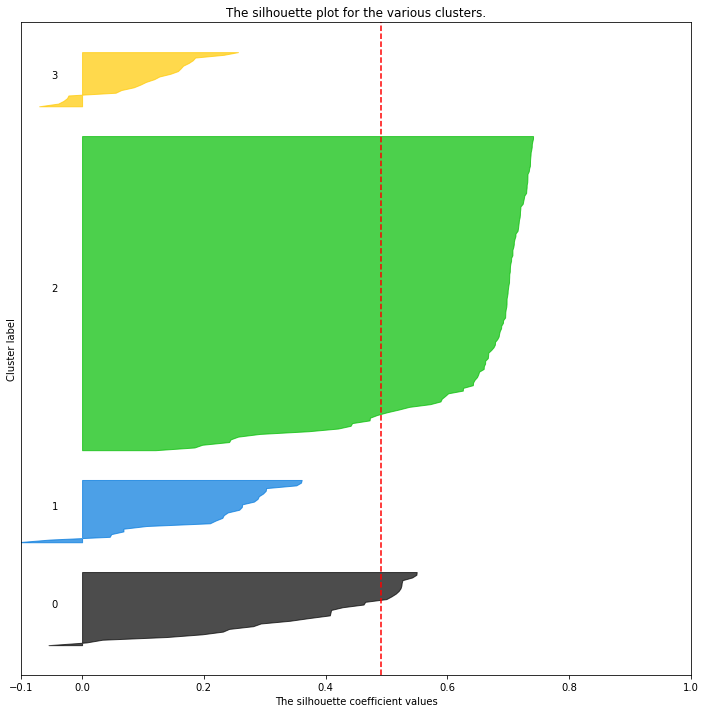

In [20]:
plot_silhouette_results(cluster_labels, silhouette_avg, sample_silhouette_values, 4, multiplier=10)

Text(0.5, 0.98, 'CPU rate analysis for KMeans clustering on sample data with n_clusters = 4')

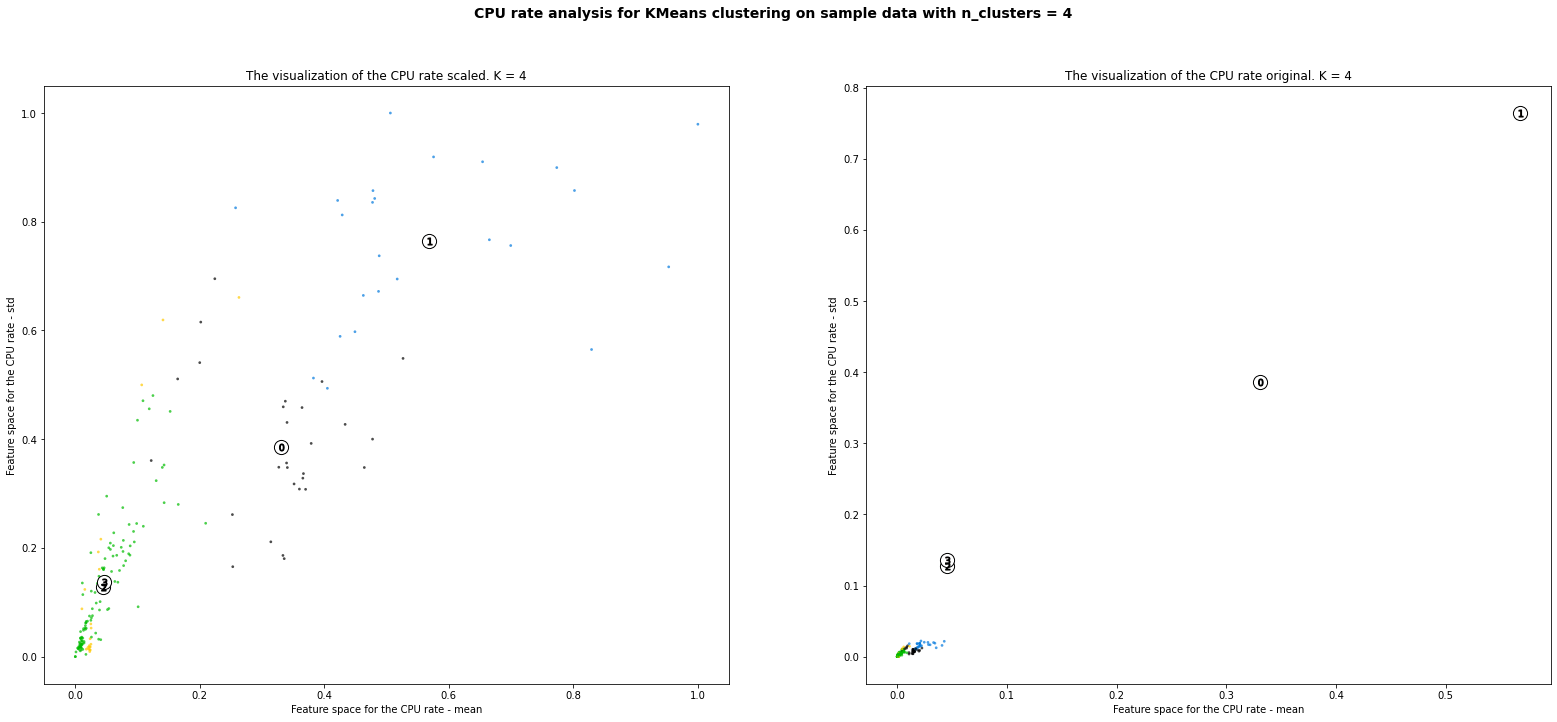

In [21]:
n_clusters = 4

feature = "CPU rate"

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(27, 11)

plot_feature_scatter(ax1, scaled, clusterer, cluster_labels, feature, 0, 1, "scaled", n_clusters)

plot_feature_scatter(ax2, user_task_usage_df.values, clusterer, cluster_labels, feature, 0, 1, "original", n_clusters)

plt.suptitle(("{feature} analysis for KMeans clustering on sample data with n_clusters = {n_clusters}".format(feature=feature, 
                                                                                                              n_clusters=n_clusters)),
             fontsize=14, fontweight='bold')

Text(0.5, 0.98, 'canonical memory usage analysis for KMeans clustering on sample data with n_clusters = 4')

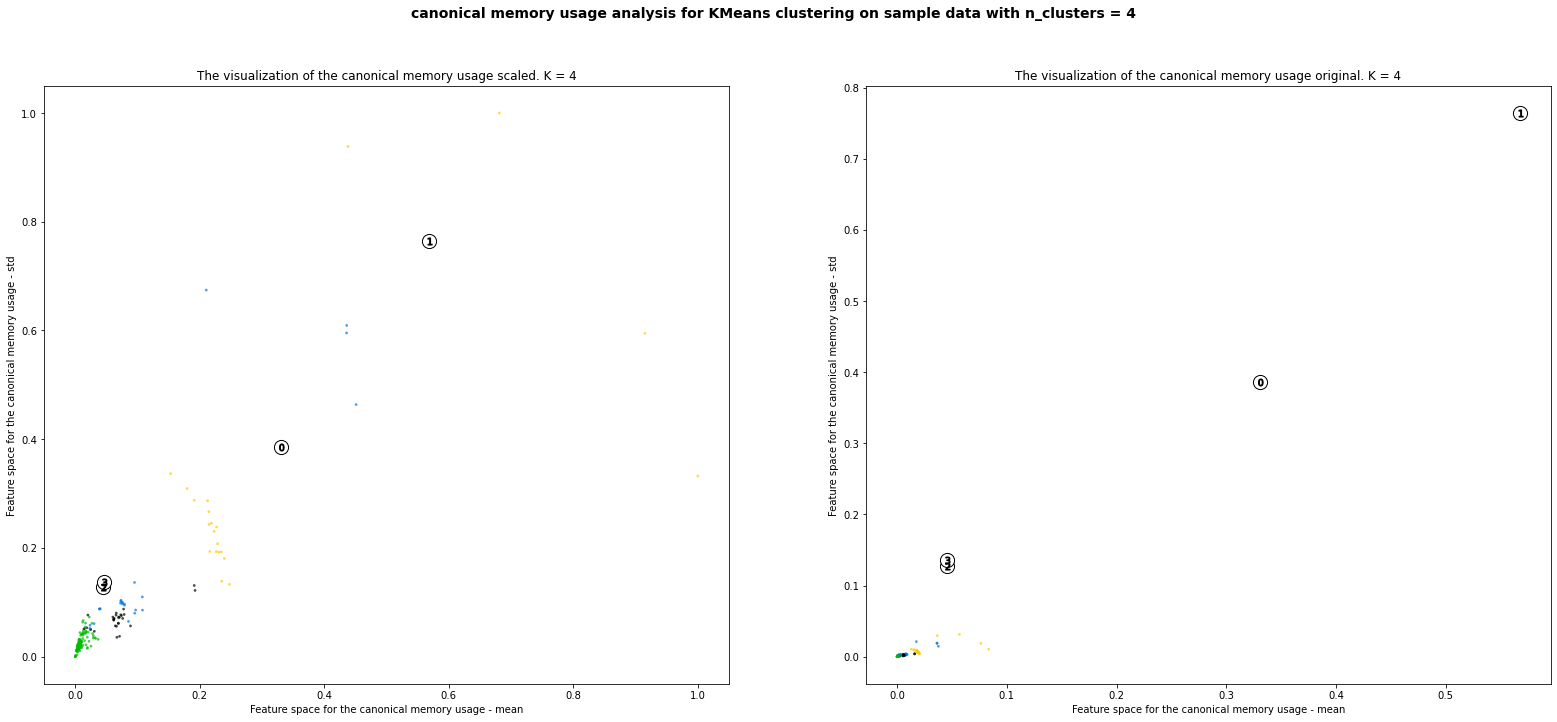

In [22]:
feature = "canonical memory usage"

dim_1 = 2
dim_2 = 3

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(27, 11)

plot_feature_scatter(ax1, scaled, clusterer, cluster_labels, feature, dim_1, dim_2, "scaled", n_clusters)

plot_feature_scatter(ax2, user_task_usage_df.values, clusterer, cluster_labels, feature, dim_1, dim_2, "original", n_clusters)

plt.suptitle(("{feature} analysis for KMeans clustering on sample data with n_clusters = {n_clusters}".format(feature=feature, 
                                                                                                              n_clusters=n_clusters)),
             fontsize=14, fontweight='bold')

Text(0.5, 0.98, 'disk usage analysis for KMeans clustering on sample data with n_clusters = 4')

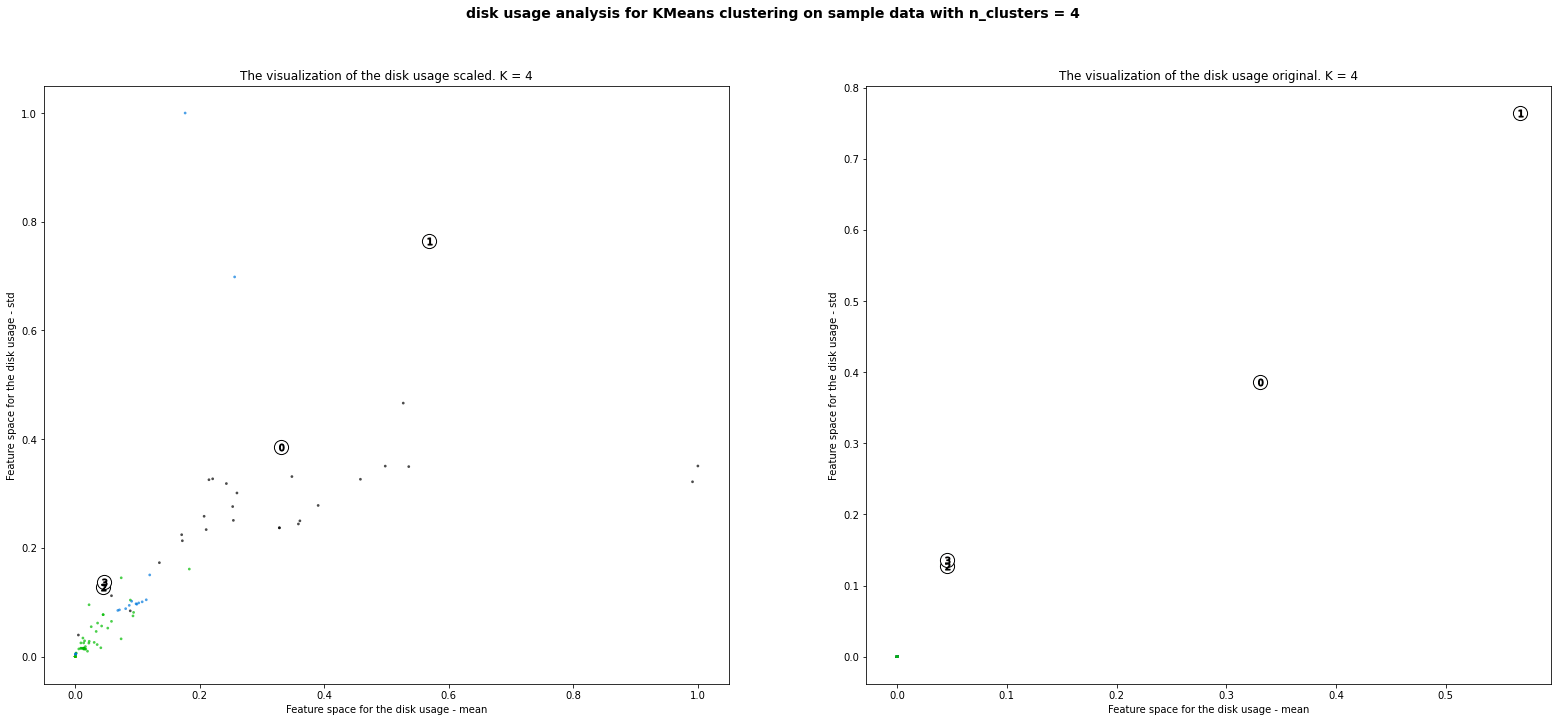

In [23]:
feature = "disk usage"

dim_1 = 4
dim_2 = 5

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(27, 11)

plot_feature_scatter(ax1, scaled, clusterer, cluster_labels, feature, dim_1, dim_2, "scaled", n_clusters)

plot_feature_scatter(ax2, user_task_usage_df.values, clusterer, cluster_labels, feature, dim_1, dim_2, "original", n_clusters)

plt.suptitle(("{feature} analysis for KMeans clustering on sample data with n_clusters = {n_clusters}".format(feature=feature, 
                                                                                                              n_clusters=n_clusters)),
             fontsize=14, fontweight='bold')

Text(0.5, 0.98, 'active tasks analysis for KMeans clustering on sample data with n_clusters = 4')

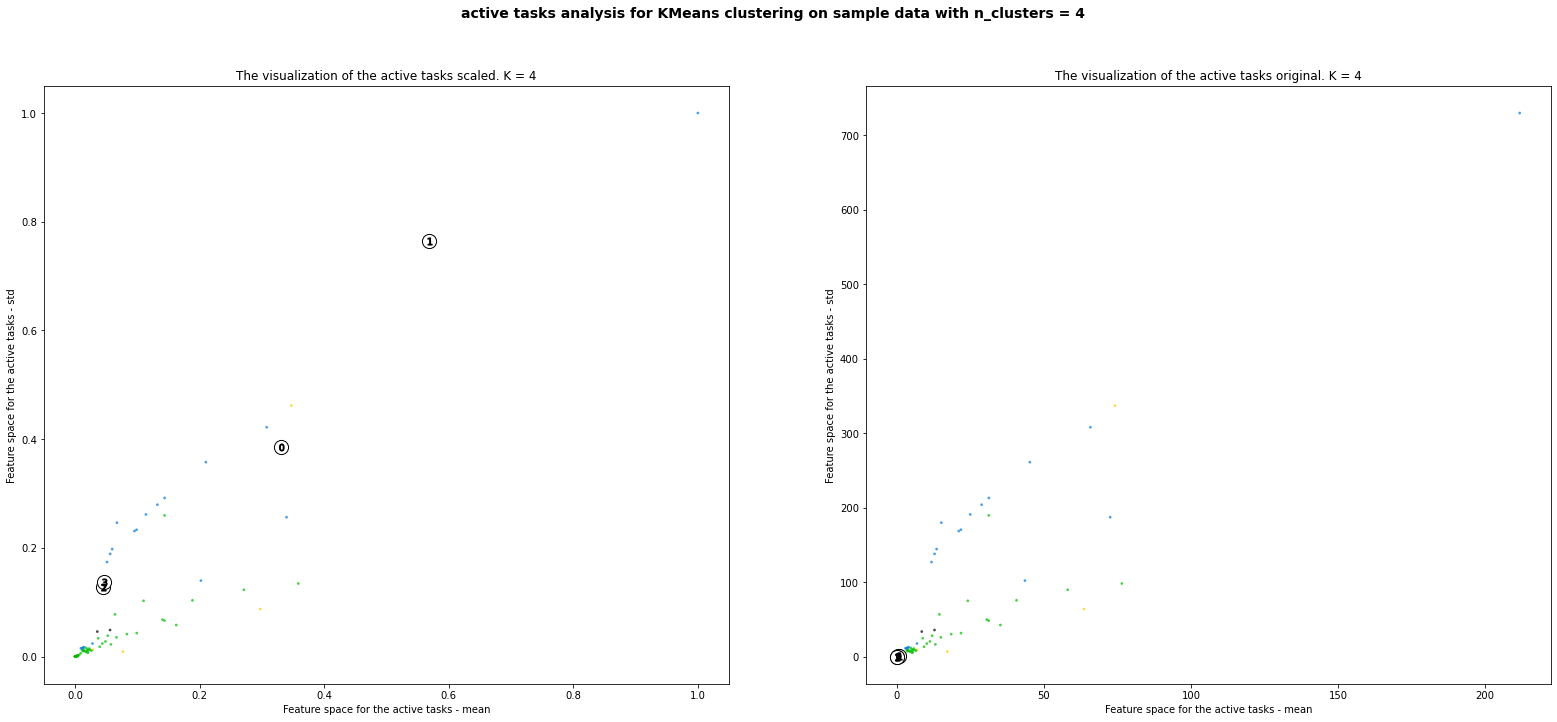

In [24]:
feature = "active tasks"

dim_1 = 6
dim_2 = 7

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(27, 11)

plot_feature_scatter(ax1, scaled, clusterer, cluster_labels, feature, dim_1, dim_2, "scaled", n_clusters)

plot_feature_scatter(ax2, user_task_usage_df.values, clusterer, cluster_labels, feature, dim_1, dim_2, "original", n_clusters)

plt.suptitle(("{feature} analysis for KMeans clustering on sample data with n_clusters = {n_clusters}".format(feature=feature, 
                                                                                                              n_clusters=n_clusters)),
             fontsize=14, fontweight='bold')

Text(0.5, 0.98, 'runtime analysis for KMeans clustering on sample data with n_clusters = 4')

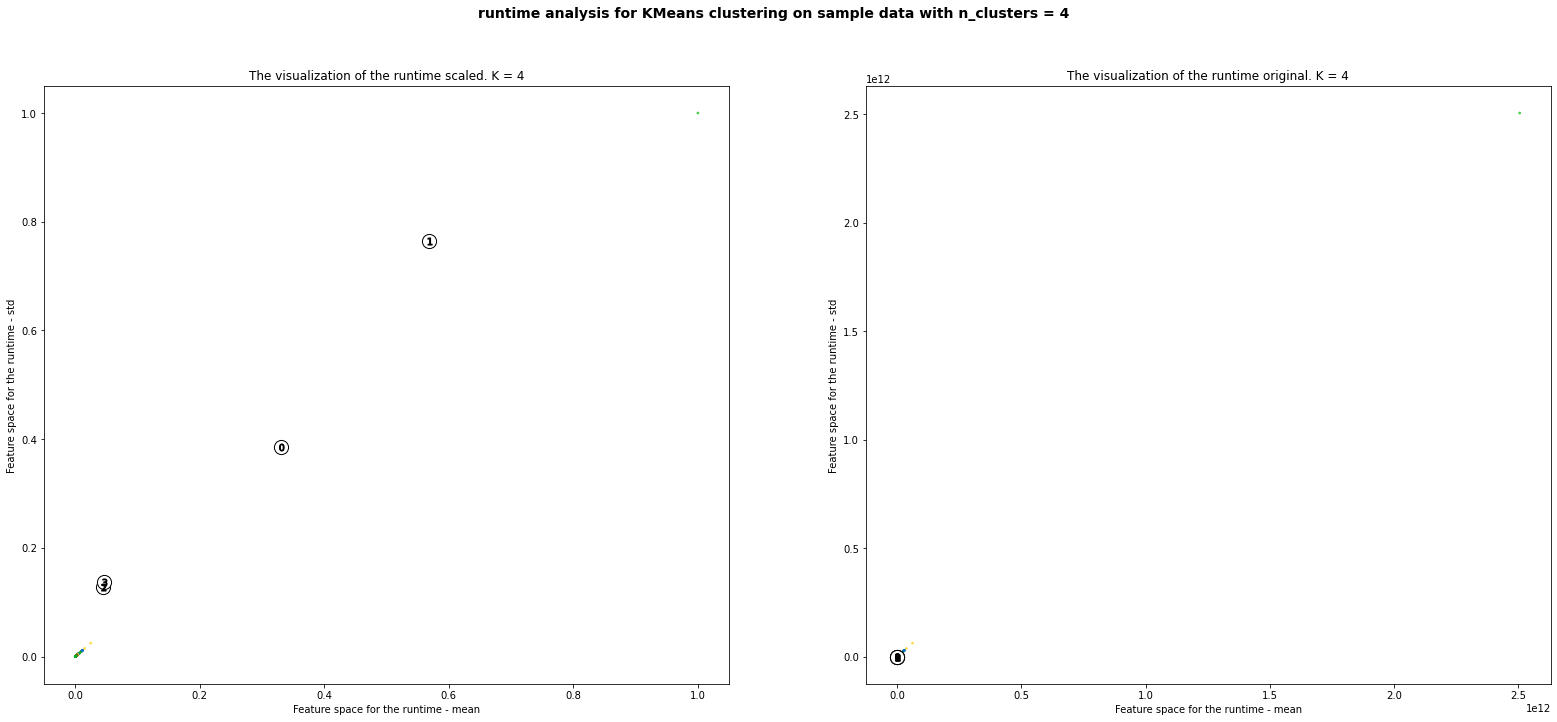

In [25]:
feature = "runtime"

dim_1 = 8
dim_2 = 8

# 2nd Plot showing the actual clusters formed - scaled
#plt.figure(figsize=(12,12))
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(27, 11)

plot_feature_scatter(ax1, scaled, clusterer, cluster_labels, feature, dim_1, dim_2, "scaled", n_clusters)

plot_feature_scatter(ax2, user_task_usage_df.values, clusterer, cluster_labels, feature, dim_1, dim_2, "original", n_clusters)

plt.suptitle(("{feature} analysis for KMeans clustering on sample data with n_clusters = {n_clusters}".format(feature=feature, 
                                                                                                              n_clusters=n_clusters)),
             fontsize=14, fontweight='bold')

## Update

In [26]:
user_metadata["K-Means = 4 new"] = cluster_labels

/tmp/ipykernel_68293/3248496046.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_metadata["K-Means = 4 new"] = cluster_labels


## Create oneHot encoding

In [27]:
oneHotDf = user_metadata[['different machines restriction', 'disk space request - Quartiles', 'memory request - Quartiles', 'CPU request - Quartiles', 'priority labels', 'user', 'logical job name', 'scheduling class']]

In [28]:
oneHotDf = pd.get_dummies(oneHotDf)

In [29]:
oneHotDf

,different machines restriction,scheduling class,disk space request - Quartiles_Q1,disk space request - Quartiles_Q2,disk space request - Quartiles_Q4,memory request - Quartiles_Q1,memory request - Quartiles_Q2,memory request - Quartiles_Q3,memory request - Quartiles_Q4,CPU request - Quartiles_Q1,...,logical job name_s0nFxuvXLxQXqQtPB0/DGtQ4s5qZ7v5klus0dAiwkO4=,logical job name_sh2+azqnWz5wf8ZmJsTBMth0xAQkyNGaUlK2s3uq50c=,logical job name_swBGfKKOxXrHehHaPw6t/2EfPLVi4GJzIgQcDb/6KWM=,logical job name_uxJBwn4+Ue4VL/HIi7a+0MfIcUlhRVpKwDdn5iPN1R8=,logical job name_vEZciGV61AjVZX9L83VJr8O3rT1DP094e2uHbksUjxs=,logical job name_yUcoKNSDOcjVXBq4jjc9G7WSztqiG4rp3PIHlfKAgBA=,logical job name_yVIRahrv8Z2KjOxCDQb3Y6flkxNj/h+w2fRbjVEk2BE=,logical job name_zJZMGR20g6eKwI7qa/4PXk8u1Q+keq0asAokMG/Gy8k=,logical job name_zQSNnHa/M/Mz9atyv0jkyDeloLh4SC/vumFDjkeaxrQ=,logical job name_zjs21/6QU0kMUI44u8XOi4vvdsxS49aw3IFUXhFf0M8=
321,0,2,0,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1015,0,2,0,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1559,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1560,0,2,0,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1922,0,2,0,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64612,0,2,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
64613,0,2,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
64648,0,2,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
64685,0,2,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Metadata analysis

Here, we compare the difference in the distribution of the static feature values in the general clustering and in the more detailed result with the ad-hoc k-Means on the user workload.

K-Means = 4             0    1    2         3
priority labels                              
Free [0,1]       0.877551  1.0  1.0  0.789474
Production [9]   0.122449  0.0  0.0  0.210526


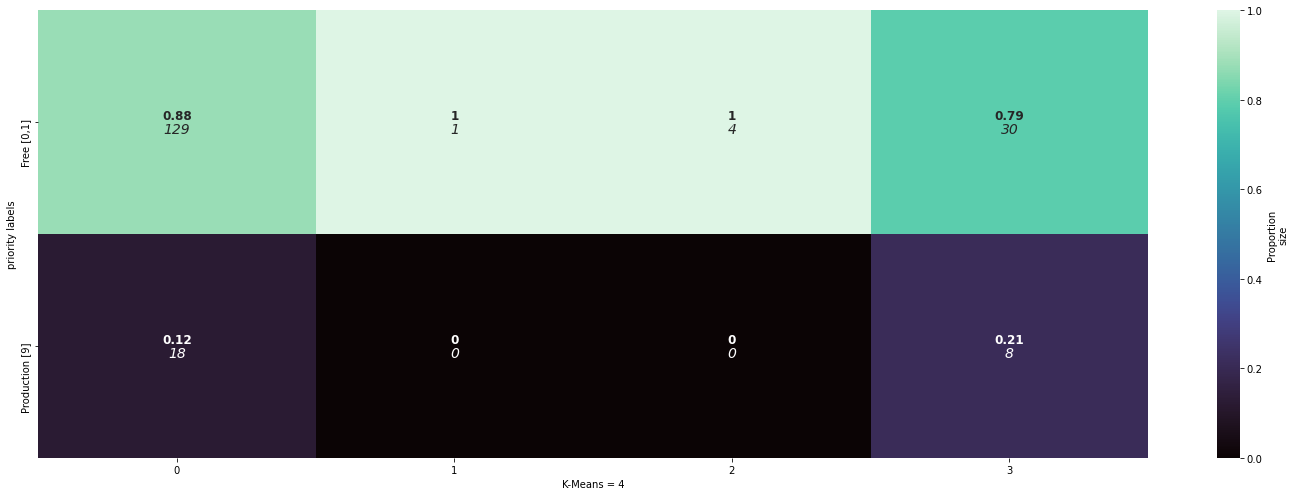

In [30]:
heatmap_df = user_metadata.groupby(["priority labels", "K-Means = 4"])["priority labels"].count()
heatmap_df


heatmap_df = heatmap_df.to_frame()
heatmap_df.columns = ["priority count"]

heatmap_df_total = heatmap_df.reset_index()
heatmap_df_total = heatmap_df_total.pivot("priority labels", "K-Means = 4", "priority count").fillna(0).astype(int)

heatmap_df_perc = heatmap_df.groupby(level=[1]).apply(lambda g: g / g.sum())
heatmap_df_perc = heatmap_df_perc.reset_index()
heatmap_df_perc = heatmap_df_perc.pivot("priority labels", "K-Means = 4", "priority count").fillna(0)
heatmap_df_perc

print(heatmap_df_perc)

plt.figure(figsize=(20,7))
sns.heatmap(heatmap_df_perc, annot=True, annot_kws={'va': 'bottom', 'fontweight': 'bold', 'fontsize': 'large'}, cmap="mako", cbar_kws={'label': 'Proportion'+'\n'+'size'})
sns.heatmap(heatmap_df_perc, annot=heatmap_df_total, annot_kws={'va': 'top', 'size': 14, 'fontstyle': 'italic'}, fmt="d", cmap="mako", cbar=False)
plt.tight_layout()
# ## #plt.savefig('figures/2021-11-28-presentation/priority_labels_heatmap_k4.svg')

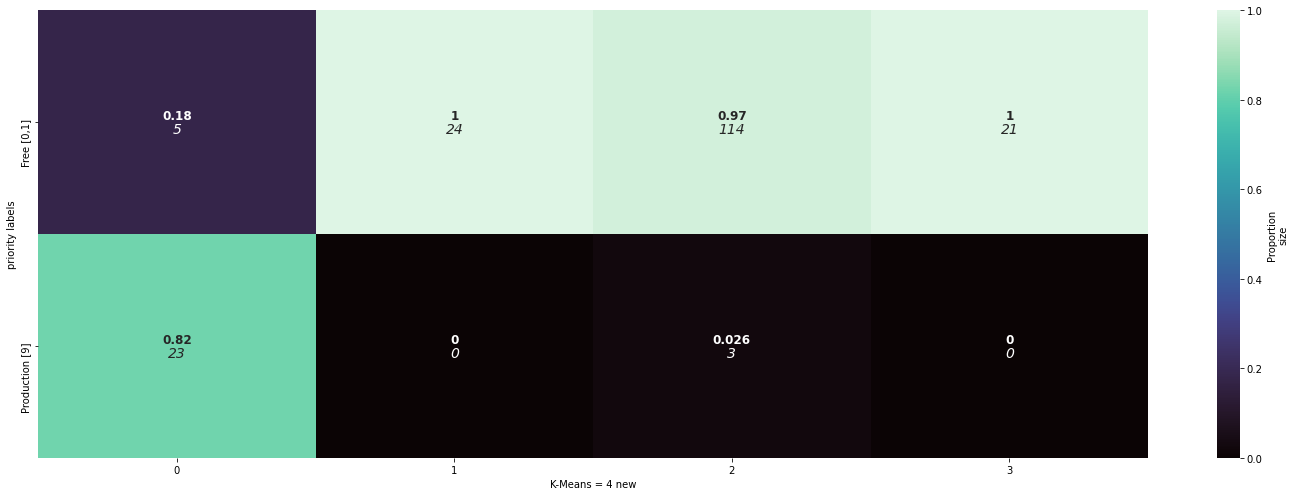

In [31]:
heatmap_df = user_metadata.groupby(["priority labels", "K-Means = 4 new"])["priority labels"].count()

heatmap_df = heatmap_df.to_frame()
heatmap_df.columns = ["priority count"]

heatmap_df_total = heatmap_df.reset_index()
heatmap_df_total = heatmap_df_total.pivot("priority labels", "K-Means = 4 new", "priority count").fillna(0).astype(int)

heatmap_df_perc = heatmap_df.groupby(level=[1]).apply(lambda g: g / g.sum())
heatmap_df_perc = heatmap_df_perc.reset_index()
heatmap_df_perc = heatmap_df_perc.pivot("priority labels", "K-Means = 4 new", "priority count").fillna(0)

plt.figure(figsize=(20,7))
sns.heatmap(heatmap_df_perc, annot=True, annot_kws={'va': 'bottom', 'fontweight': 'bold', 'fontsize': 'large'}, cmap="mako", cbar_kws={'label': 'Proportion'+'\n'+'size'})
sns.heatmap(heatmap_df_perc, annot=heatmap_df_total, annot_kws={'va': 'top', 'size': 14, 'fontstyle': 'italic'}, fmt="d", cmap="mako", cbar=False)
plt.tight_layout()
# ## #plt.savefig('figures/2021-11-28-presentation/priority_labels_heatmap_k4.svg')

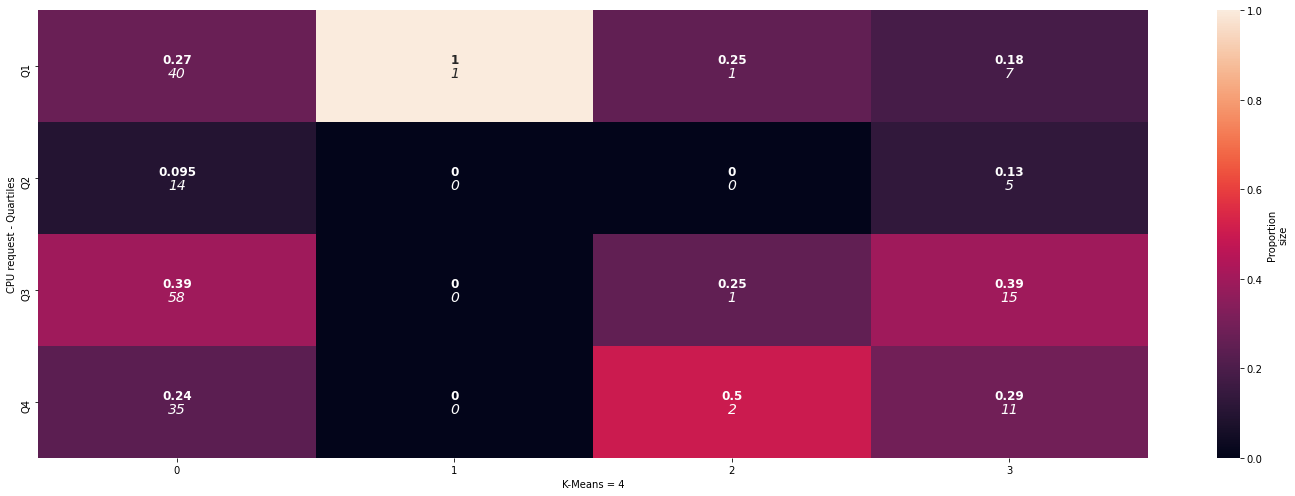

In [32]:
k=4
heatmap_df = user_metadata.groupby(["CPU request - Quartiles", f"K-Means = {k}"])["CPU request - Quartiles"].count()
heatmap_df = heatmap_df.to_frame()
heatmap_df.columns = ["quartiles count"]

heatmap_df_total = heatmap_df.reset_index()
heatmap_df_total = heatmap_df_total.pivot("CPU request - Quartiles", f"K-Means = {k}", "quartiles count").fillna(0).astype(int)
#heatmap_df_total["total"] = heatmap_df.groupby("priority labels").sum().values

#plt.figure(figsize=(20,7))
#sns.heatmap(heatmap_df_total, annot=True, fmt="d")
#
heatmap_df_perc = heatmap_df.groupby(level=[1]).apply(lambda g: g / g.sum())
heatmap_df_perc = heatmap_df_perc.reset_index()
heatmap_df_perc["CPU request - Quartiles"] = pd.Categorical(heatmap_df_perc["CPU request - Quartiles"], categories=['Q1', 'Q2', 'Q3', 'Q4'])

heatmap_df_perc = heatmap_df_perc.pivot("CPU request - Quartiles", f"K-Means = {k}", "quartiles count").fillna(0)


plt.figure(figsize=(20,7))
sns.heatmap(heatmap_df_perc, annot=True, annot_kws={'va': 'bottom', 'fontweight': 'bold', 'fontsize': 'large'}, cmap="rocket", cbar_kws={'label': 'Proportion'+'\n'+'size'})
sns.heatmap(heatmap_df_perc, annot=heatmap_df_total, annot_kws={'va': 'top', 'size': 14, 'fontstyle': 'italic'}, fmt="d", cmap="rocket", cbar=False)
plt.tight_layout()
#plt.savefig(f'figures/2021-11-28-presentation/cpu_requests_heatmap_k{k}.svg')

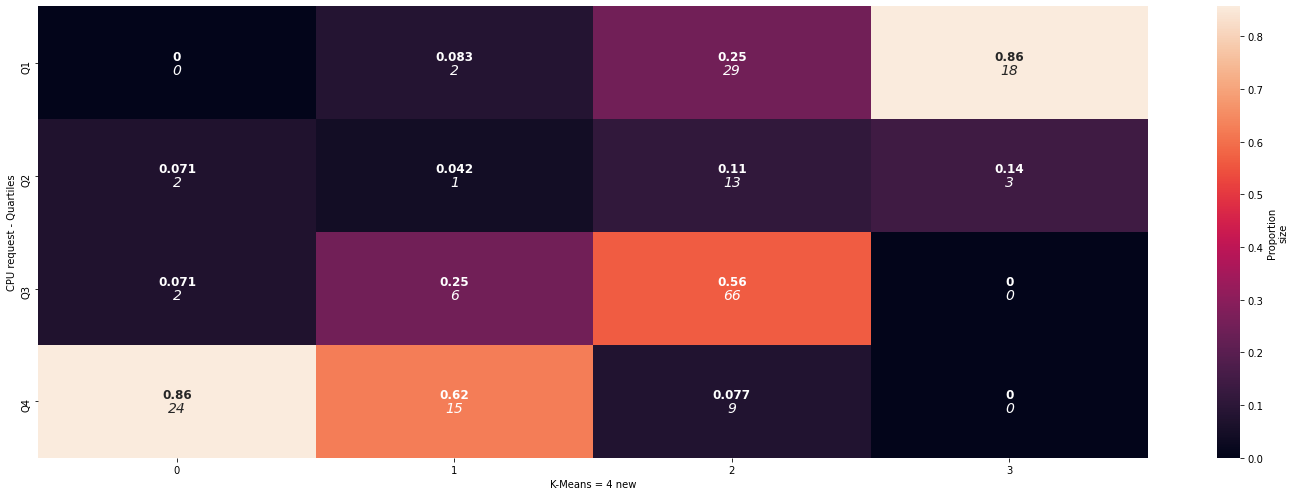

In [33]:
k=4
heatmap_df = user_metadata.groupby(["CPU request - Quartiles", f"K-Means = {k} new"])["CPU request - Quartiles"].count()
heatmap_df = heatmap_df.to_frame()
heatmap_df.columns = ["quartiles count"]

heatmap_df_total = heatmap_df.reset_index()
heatmap_df_total = heatmap_df_total.pivot("CPU request - Quartiles", f"K-Means = {k} new", "quartiles count").fillna(0).astype(int)
#heatmap_df_total["total"] = heatmap_df.groupby("priority labels").sum().values

#plt.figure(figsize=(20,7))
#sns.heatmap(heatmap_df_total, annot=True, fmt="d")
#
heatmap_df_perc = heatmap_df.groupby(level=[1]).apply(lambda g: g / g.sum())
heatmap_df_perc = heatmap_df_perc.reset_index()
heatmap_df_perc["CPU request - Quartiles"] = pd.Categorical(heatmap_df_perc["CPU request - Quartiles"], categories=['Q1', 'Q2', 'Q3', 'Q4'])

heatmap_df_perc = heatmap_df_perc.pivot("CPU request - Quartiles", f"K-Means = {k} new", "quartiles count").fillna(0)


plt.figure(figsize=(20,7))
sns.heatmap(heatmap_df_perc, annot=True, annot_kws={'va': 'bottom', 'fontweight': 'bold', 'fontsize': 'large'}, cmap="rocket", cbar_kws={'label': 'Proportion'+'\n'+'size'})
sns.heatmap(heatmap_df_perc, annot=heatmap_df_total, annot_kws={'va': 'top', 'size': 14, 'fontstyle': 'italic'}, fmt="d", cmap="rocket", cbar=False)
plt.tight_layout()
#plt.savefig(f'figures/2021-11-28-presentation/cpu_requests_heatmap_k{k}.svg')

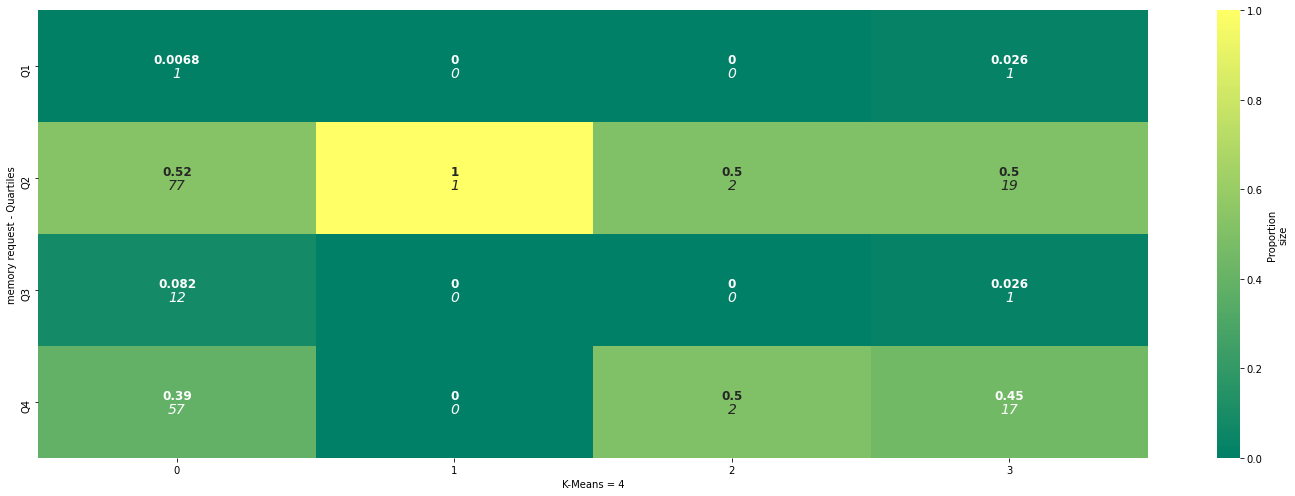

In [34]:
heatmap_df = user_metadata.groupby(["memory request - Quartiles", "K-Means = 4"])["memory request - Quartiles"].count()
heatmap_df = heatmap_df.to_frame()
heatmap_df.columns = ["quartiles count"]

heatmap_df_total = heatmap_df.reset_index()
heatmap_df_total = heatmap_df_total.pivot("memory request - Quartiles", "K-Means = 4", "quartiles count").fillna(0).astype(int)
#heatmap_df_total["total"] = heatmap_df.groupby("priority labels").sum().values

#plt.figure(figsize=(20,7))
#sns.heatmap(heatmap_df_total, annot=True, fmt="d")
#
heatmap_df_perc = heatmap_df.groupby(level=[1]).apply(lambda g: g / g.sum())
heatmap_df_perc = heatmap_df_perc.reset_index()
heatmap_df_perc["memory request - Quartiles"] = pd.Categorical(heatmap_df_perc["memory request - Quartiles"], categories=['Q1', 'Q2', 'Q3', 'Q4'])

heatmap_df_perc = heatmap_df_perc.pivot("memory request - Quartiles", "K-Means = 4", "quartiles count").fillna(0)


plt.figure(figsize=(20,7))
sns.heatmap(heatmap_df_perc, annot=True, annot_kws={'va': 'bottom', 'fontweight': 'bold', 'fontsize': 'large'}, cmap="summer", cbar_kws={'label': 'Proportion'+'\n'+'size'})
sns.heatmap(heatmap_df_perc, annot=heatmap_df_total, annot_kws={'va': 'top', 'size': 14, 'fontstyle': 'italic'}, fmt="d", cmap="summer", cbar=False)
plt.tight_layout()
#plt.savefig('figures/2021-11-28-presentation/memory_requests_heatmap_k10.svg')

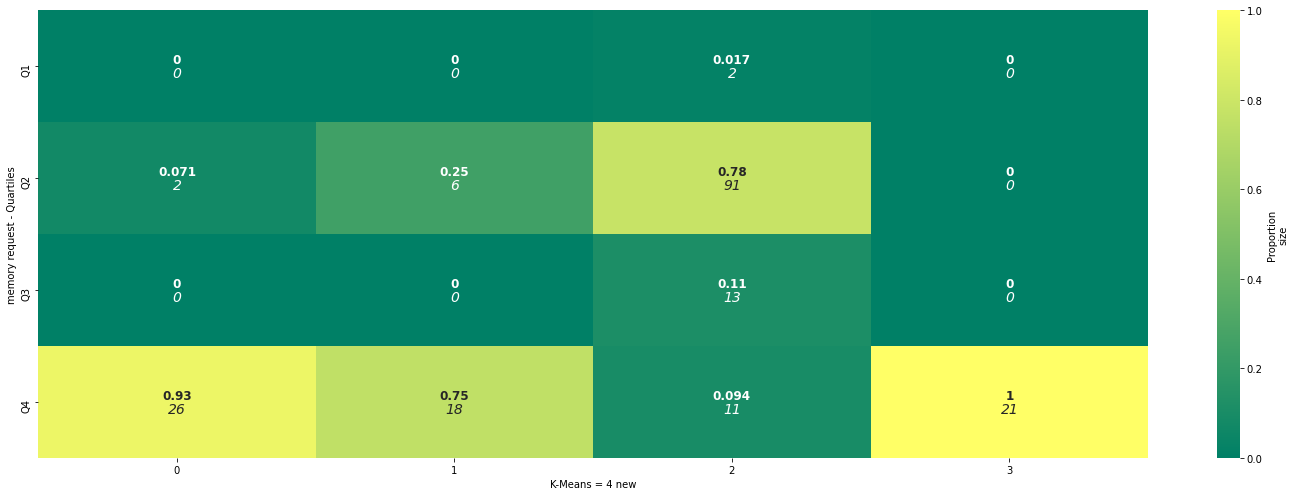

In [35]:
heatmap_df = user_metadata.groupby(["memory request - Quartiles", "K-Means = 4 new"])["memory request - Quartiles"].count()
heatmap_df = heatmap_df.to_frame()
heatmap_df.columns = ["quartiles count"]

heatmap_df_total = heatmap_df.reset_index()
heatmap_df_total = heatmap_df_total.pivot("memory request - Quartiles", "K-Means = 4 new", "quartiles count").fillna(0).astype(int)
#heatmap_df_total["total"] = heatmap_df.groupby("priority labels").sum().values

#plt.figure(figsize=(20,7))
#sns.heatmap(heatmap_df_total, annot=True, fmt="d")
#
heatmap_df_perc = heatmap_df.groupby(level=[1]).apply(lambda g: g / g.sum())
heatmap_df_perc = heatmap_df_perc.reset_index()
heatmap_df_perc["memory request - Quartiles"] = pd.Categorical(heatmap_df_perc["memory request - Quartiles"], categories=['Q1', 'Q2', 'Q3', 'Q4'])

heatmap_df_perc = heatmap_df_perc.pivot("memory request - Quartiles", "K-Means = 4 new", "quartiles count").fillna(0)


plt.figure(figsize=(20,7))
sns.heatmap(heatmap_df_perc, annot=True, annot_kws={'va': 'bottom', 'fontweight': 'bold', 'fontsize': 'large'}, cmap="summer", cbar_kws={'label': 'Proportion'+'\n'+'size'})
sns.heatmap(heatmap_df_perc, annot=heatmap_df_total, annot_kws={'va': 'top', 'size': 14, 'fontstyle': 'italic'}, fmt="d", cmap="summer", cbar=False)
plt.tight_layout()
#plt.savefig('figures/2021-11-28-presentation/memory_requests_heatmap_k10.svg')

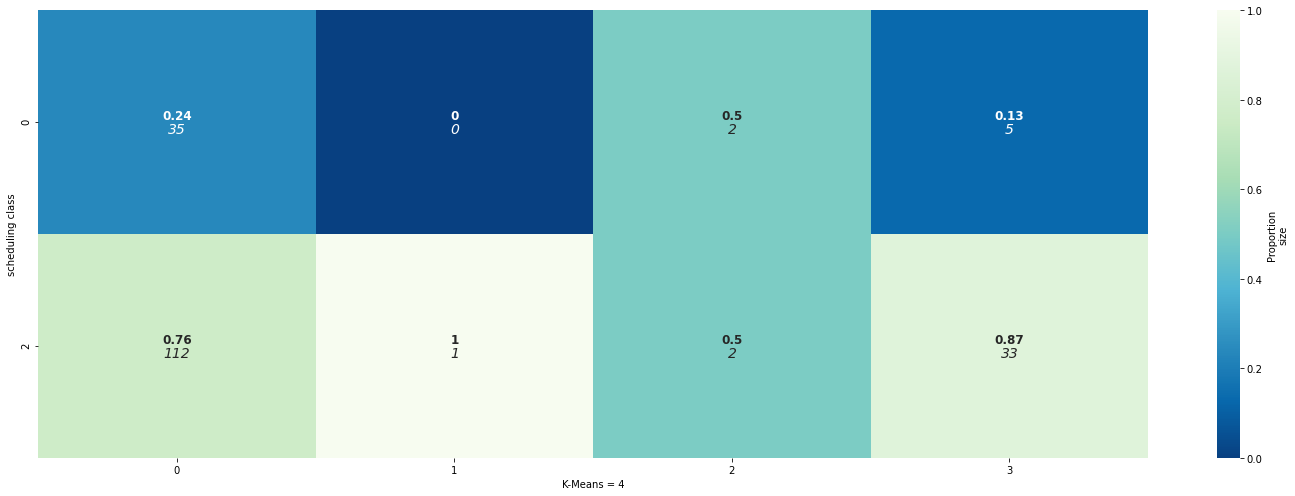

In [36]:
k=4
target_metric="scheduling class"

heatmap_df = user_metadata.groupby([target_metric, f"K-Means = {k}"])[target_metric].count()
heatmap_df = heatmap_df.to_frame()
heatmap_df.columns = ["quartiles count"]

heatmap_df_total = heatmap_df.reset_index()
heatmap_df_total = heatmap_df_total.pivot(target_metric, f"K-Means = {k}", "quartiles count").fillna(0).astype(int)
#heatmap_df_total["total"] = heatmap_df.groupby("priority labels").sum().values

#plt.figure(figsize=(20,7))
#sns.heatmap(heatmap_df_total, annot=True, fmt="d")
#
heatmap_df_perc = heatmap_df.groupby(level=[1]).apply(lambda g: g / g.sum())
heatmap_df_perc = heatmap_df_perc.reset_index()
heatmap_df_perc[target_metric] = pd.Categorical(heatmap_df_perc[target_metric], categories=[0, 1, 2, 3])

heatmap_df_perc = heatmap_df_perc.pivot(target_metric, f"K-Means = {k}", "quartiles count").fillna(0)


plt.figure(figsize=(20,7))
sns.heatmap(heatmap_df_perc, annot=True, annot_kws={'va': 'bottom', 'fontweight': 'bold', 'fontsize': 'large'}, cmap="GnBu_r", cbar_kws={'label': 'Proportion'+'\n'+'size'})
sns.heatmap(heatmap_df_perc, annot=heatmap_df_total, annot_kws={'va': 'top', 'size': 14, 'fontstyle': 'italic'}, fmt="d", cmap="GnBu_r", cbar=False)
plt.tight_layout()
plt.savefig(f'figures/2021-11-28-presentation/schedclass_heatmap_k{k}.svg')

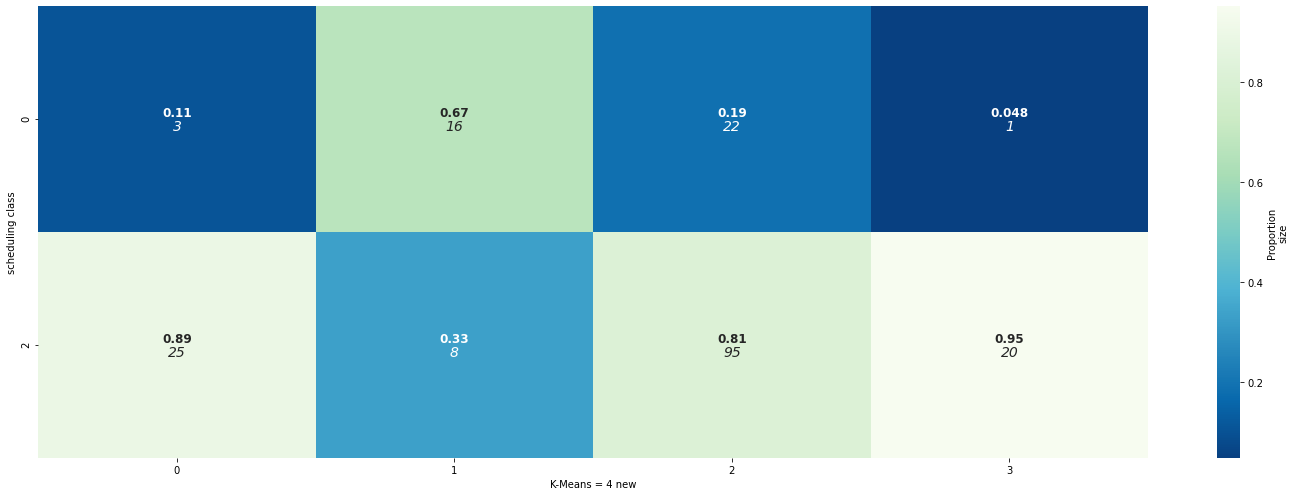

In [37]:
k=4
target_metric="scheduling class"

heatmap_df = user_metadata.groupby([target_metric, f"K-Means = {k} new"])[target_metric].count()
heatmap_df = heatmap_df.to_frame()
heatmap_df.columns = ["quartiles count"]

heatmap_df_total = heatmap_df.reset_index()
heatmap_df_total = heatmap_df_total.pivot(target_metric, f"K-Means = {k} new", "quartiles count").fillna(0).astype(int)
#heatmap_df_total["total"] = heatmap_df.groupby("priority labels").sum().values

#plt.figure(figsize=(20,7))
#sns.heatmap(heatmap_df_total, annot=True, fmt="d")
#
heatmap_df_perc = heatmap_df.groupby(level=[1]).apply(lambda g: g / g.sum())
heatmap_df_perc = heatmap_df_perc.reset_index()
heatmap_df_perc[target_metric] = pd.Categorical(heatmap_df_perc[target_metric], categories=[0, 1, 2, 3])

heatmap_df_perc = heatmap_df_perc.pivot(target_metric, f"K-Means = {k} new", "quartiles count").fillna(0)


plt.figure(figsize=(20,7))
sns.heatmap(heatmap_df_perc, annot=True, annot_kws={'va': 'bottom', 'fontweight': 'bold', 'fontsize': 'large'}, cmap="GnBu_r", cbar_kws={'label': 'Proportion'+'\n'+'size'})
sns.heatmap(heatmap_df_perc, annot=heatmap_df_total, annot_kws={'va': 'top', 'size': 14, 'fontstyle': 'italic'}, fmt="d", cmap="GnBu_r", cbar=False)
plt.tight_layout()
plt.savefig(f'figures/2021-11-28-presentation/schedclass_heatmap_k{k}.svg')

## XGBoost

In [38]:
model = xgb.XGBClassifier(tree_method='gpu_hist')

In [39]:
oneHotDf.columns = [col.replace('[', '').replace(']','').replace(',',' ').replace(' ', '_').replace(' ', '') for col in oneHotDf.columns]

#### K-Means 4 - cl.0

In [40]:
model.fit(oneHotDf, (user_metadata['K-Means = 4'] == 0).astype(int).values)

/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:32:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=0, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=80,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [41]:
model.get_booster().get_score(importance_type='gain')

{'scheduling_class': 0.043836984783411026,
 'disk_space_request_-_Quartiles_Q1': 0.5545803904533386,
 'disk_space_request_-_Quartiles_Q2': 0.08822868764400482,
 'disk_space_request_-_Quartiles_Q4': 0.04577844962477684,
 'memory_request_-_Quartiles_Q2': 0.06778456270694733,
 'memory_request_-_Quartiles_Q3': 0.09083481132984161,
 'memory_request_-_Quartiles_Q4': 0.024448048323392868,
 'CPU_request_-_Quartiles_Q1': 0.039329662919044495,
 'CPU_request_-_Quartiles_Q2': 0.08986657112836838,
 'CPU_request_-_Quartiles_Q3': 0.041036322712898254,
 'CPU_request_-_Quartiles_Q4': 0.11688001453876495,
 'priority_labels_Free_0_1': 0.04811729118227959,
 'logical_job_name_F1BfEnSeC8ZBresily11DA02jCLrIE6Svxxw0csgAuU=': 0.04466798156499863,
 'logical_job_name_Uz1FE3xBXQAVTIjiZlJjuewGhvo+vb+494mMeR18zT8=': 0.12751798331737518,
 'logical_job_name_f7WFf9GHe6IJiWeFjqoqhEKiQ94wHFwI1e05vf2/Rbo=': 0.014363223686814308,
 'logical_job_name_h8JLKv8xlfsO0x8vj/+mOJsBdPsjjsrGKWag+H5IsqU=': 0.05685177445411682,
 'logi

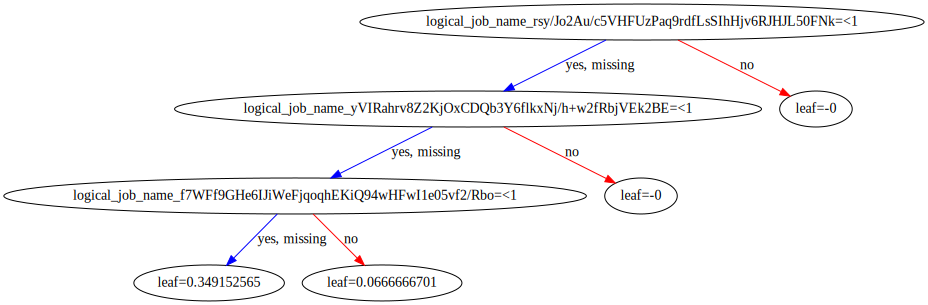

In [42]:
xgb.to_graphviz(model)

In [43]:
scoring = {'acc': 'accuracy',
           'f1_macro': 'f1_macro',
           'f1_weight': 'f1_weighted'}

In [44]:
kfold = KFold(n_splits=10)
model0 = xgb.XGBClassifier(max_depth=6, min_child_weight=1, subsample=0.8879, eta=0.099)
results0 = cross_validate(model0, oneHotDf, (user_metadata['K-Means = 4'] == 0).astype(int).values, scoring=scoring, cv=kfold)

/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:32:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:32:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:32:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:32:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:32:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:32:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:32:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:32:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:32:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:32:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [45]:
print(results0['test_acc'].mean()*100, results0['test_acc'].std()*100) 

75.26315789473685 10.27327436628586


In [46]:
print(results0['test_f1_macro'].mean()*100, results0['test_f1_macro'].std()*100) 

43.93439384947924 4.346522875095835


In [47]:
print(results0['test_f1_weight'].mean()*100, results0['test_f1_weight'].std()*100) 

67.24421539701675 14.028775608029893


#### K-Means 4 -cl.1

In [48]:
kfold = KFold(n_splits=10)
model1 = xgb.XGBClassifier(tree_method='gpu_hist')
results1 = cross_validate(model, oneHotDf, (user_metadata['K-Means = 4'] == 1).astype(int).values, scoring=scoring, cv=kfold)

[10:32:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:32:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:32:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:32:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:32:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:32:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:32:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:32:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:32:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:32:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [49]:
print(results1['test_acc'].mean()*100, results1['test_acc'].std()*100) 

99.47368421052632 1.5789473684210544


In [50]:
print(results1['test_f1_macro'].mean()*100, results1['test_f1_macro'].std()*100) 

94.86486486486486 15.405405405405403


In [51]:
print(results1['test_f1_weight'].mean()*100, results1['test_f1_weight'].std()*100) 

99.21763869132289 2.3470839260312895


In [52]:
model1.fit(oneHotDf, (user_metadata['K-Means = 4'] == 1).astype(int).values)

[10:32:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=0, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=80,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

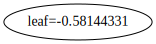

In [53]:
xgb.to_graphviz(model1)

#### K-Means 4 - cl.2

In [54]:
kfold = KFold(n_splits=10)
model2 = xgb.XGBClassifier(tree_method='gpu_hist')
results2 = cross_validate(model2, oneHotDf, (user_metadata['K-Means = 4'] == 2).astype(int).values, scoring=scoring, cv=kfold)

/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:32:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:32:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:32:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:32:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:32:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:32:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/x

[10:32:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:32:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:32:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:32:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [55]:
print(results2['test_acc'].mean()*100, results2['test_acc'].std()*100) 

97.89473684210526 3.4911839898477894


In [56]:
print(results2['test_f1_macro'].mean()*100, results2['test_f1_macro'].std()*100) 

84.45195195195195 23.752891228935173


In [57]:
print(results2['test_f1_weight'].mean()*100, results2['test_f1_weight'].std()*100) 

96.88556978030662 5.153449842623679


In [58]:
model2.fit(oneHotDf, (user_metadata['K-Means = 4'] == 2).astype(int).values)

[10:32:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=0, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=80,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

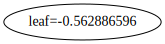

In [59]:
xgb.to_graphviz(model2)

Interpretation of the graph: https://stackoverflow.com/questions/40926340/what-does-the-value-of-leaf-in-the-following-xgboost-model-tree-diagram-means

#### K-Means 4 - cl.3

In [60]:
kfold = KFold(n_splits=10)
model3 = xgb.XGBClassifier(tree_method='gpu_hist')
results3 = cross_validate(model3, oneHotDf, (user_metadata['K-Means = 4'] == 3).astype(int).values, scoring=scoring, cv=kfold)

/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:32:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:32:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:32:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:32:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:32:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:32:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:32:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:32:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:32:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:32:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [61]:
print(results3['test_acc'].mean()*100, results3['test_acc'].std()*100) 

77.36842105263158 11.54300642076911


In [62]:
print(results3['test_f1_macro'].mean()*100, results3['test_f1_macro'].std()*100) 

49.571518759018765 17.282099099470702


In [63]:
print(results3['test_f1_weight'].mean()*100, results3['test_f1_weight'].std()*100) 

71.07261525024683 15.50074233880859


In [64]:
model3.fit(oneHotDf, (user_metadata['K-Means = 4'] == 3).astype(int).values)

[10:32:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=0, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=80,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

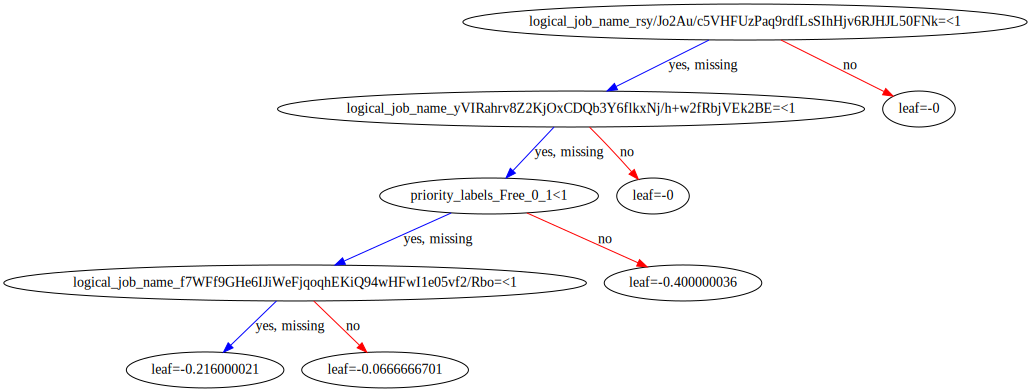

In [65]:
xgb.to_graphviz(model3)

## Watermark

In [66]:
%load_ext watermark
%watermark
%watermark --iversions

Last updated: 2022-01-26T10:32:26.316496+01:00

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 7.29.0

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 4.18.0-193.28.1.el8_2.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 80
Architecture: 64bit

numpy     : 1.21.2
matplotlib: 3.4.3
pandas    : 1.3.5
xgboost   : 1.5.2
seaborn   : 0.11.0
sklearn   : 1.0.2

